In [1]:
import pandas as pd
import sqlalchemy 
import psycopg2
import os
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from datetime import datetime as dt
import sys

In [2]:
sys.path.append('..')

In [3]:
from modules.stats import *

In [4]:
#guardar paso en csv
path='/data/ETLcache/'
now = dt.now()
timestamp = now.strftime("_%d%m%Y_%H%M%S")

In [5]:
DBname=os.environ['DB_NAME']
postgres_psswd=os.environ['POSTGRES_PASSWORD']
postgres_user=os.environ['POSTGRES_USER']
postgres_port=str(os.environ['POSTGRES_PORT'])
# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://'+postgres_user+':'+postgres_psswd+'@'+DBname+':'+postgres_port+'/superset')
# Create the connection
cnx = create_engine(postgres_str)

In [6]:
url='https://docs.google.com/spreadsheets/d/1mLx2L8nMaRZu0Sy4lyFniDewl6jDcgnxB_d0lHG-boc/export?gid=1456422453&format=csv'

In [7]:
muertes=pd.read_csv(url,header=[1],encoding='utf-8')
muertes['Fecha']=muertes['Fecha']+'/2020'
muertes['Fecha']=pd.to_datetime(muertes['Fecha'],errors='coerce',format='%d/%m/%Y').dt.to_pydatetime()
muertes=muertes.rename(columns={
    
    'Muertes COVID U07.1':'ConfirmadosPCR+',
    'Muertes Covid Hospitales según SOCHIMI et al.':'SOCHIMI',
    'Muertes COVID U07.2':'DEIS'

})
fecha=muertes['Fecha']
muertes=muertes[['ConfirmadosPCR+','SOCHIMI','DEIS']]
muertes['SOCHIMI']=muertes['SOCHIMI']+muertes['ConfirmadosPCR+']
muertes['DEIS']=muertes['DEIS']+muertes['ConfirmadosPCR+']
muertes_cumsum=muertes.cumsum()
muertes_cumsum.columns=[str(col) + '_TOT' for col in muertes_cumsum.columns]

In [8]:
muertes_log=np.log(muertes+0.0001)
muertes_log[muertes_log<1]=0
muertes_log.columns=['LOG('+str(col) + ')' for col in muertes_log.columns]

In [9]:
muertes_cumsum_log=np.log(muertes_cumsum+0.0001)
muertes_cumsum_log[muertes_cumsum_log<1]=0
muertes_cumsum_log.columns=['LOG('+str(col) + ')' for col in muertes_cumsum_log.columns]

In [10]:
muertes=pd.concat([fecha,muertes,muertes_log,muertes_cumsum,muertes_cumsum_log],axis=1)

In [11]:
pop=pd.read_sql_table('producto1_Covid_19', schema='producto1',con=cnx) 
pop=pop.groupby('Region')['Poblacion'].sum()
popTOT=pop.sum()

In [12]:
muertesMM=(muertes[['ConfirmadosPCR+_TOT','SOCHIMI_TOT','DEIS_TOT']]/popTOT*1000000).round(decimals=2)
muertesMM.columns=[col.replace('_TOT','_MM') for col in muertesMM.columns]

In [13]:
muertesMM_LOG=np.log(muertesMM+0.0001)
muertesMM_LOG[muertesMM_LOG<1]=0
muertesMM_LOG.columns=['LOG('+str(col) + ')' for col in muertesMM_LOG.columns]

In [14]:
muertes=pd.concat([muertes,muertesMM,muertesMM_LOG],axis=1)
muertes=muertes.fillna(0)
muertes = muertes.loc[:,~muertes.columns.duplicated()]

In [15]:
muertes=regression(muertes,term1='LOG',term2='_TOT')

In [16]:
muertes=regression(muertes,term1='LOG',term2='_MM')

In [17]:
params=[{'x':'LOG(DEIS_TOT)','y':'LOG(DEIS)','z':"LOG(DEIS_TOT)_Regress",'xlabel':'Fecha','ylabel':'DEIS',
             'x_label':'Fecha','y_label':'Muertes Diarias','title':'Muertes DEIS'},
{'x':'LOG(SOCHIMI_TOT)','y':'LOG(SOCHIMI)','z':"LOG(SOCHIMI_TOT)_Regress",'xlabel':'Fecha','ylabel':'SOCHIMI',
             'x_label':'Fecha','y_label':'Muertes Diarias','title':'Muertes SOCHIMI'},
{'x':'LOG(ConfirmadosPCR+_TOT)','y':'LOG(ConfirmadosPCR+)','z':"LOG(ConfirmadosPCR+_TOT)_Regress",'xlabel':'Fecha','ylabel':'ConfirmadosPCR+',
             'x_label':'Fecha','y_label':'Muertes Diarias','title':'Muertes ConfirmadosPCR+'}]

In [18]:
params2=[{'x':'LOG(DEIS_MM)','y':'LOG(DEIS)','z':"LOG(DEIS_MM)_Regress",'xlabel':'DEIS_MM','ylabel':'DEIS',
             'x_label':'Muertes por Millón Hab.','y_label':'Muertes Diarias','title':'Muertes por Millón Hab. DEIS'},
{'x':'LOG(SOCHIMI_MM)','y':'LOG(SOCHIMI)','z':"LOG(SOCHIMI_MM)_Regress",'xlabel':'SOCHIMI_MM','ylabel':'SOCHIMI',
             'x_label':'Muertes por Millón Hab.','y_label':'Muertes Diarias','title':'Muertes por Millón Hab. SOCHIMI'},
{'x':'LOG(ConfirmadosPCR+_MM)','y':'LOG(ConfirmadosPCR+)','z':"LOG(ConfirmadosPCR+_MM)_Regress",'xlabel':'ConfirmadosPCR+_MM','ylabel':'ConfirmadosPCR+',
             'x_label':'Muertes por Millón Hab.','y_label':'Muertes Diarias','title':'Muertes por Millón Hab. ConfirmadosPCR+'}]

saving to file: /data/ETLcache/Muertes_DEIS.png
saving backup: /data/ETLcache/Muertes_DEIS_24012021_051644.png


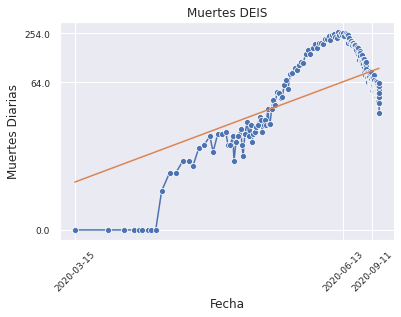

saving to file: /data/ETLcache/Muertes_SOCHIMI.png
saving backup: /data/ETLcache/Muertes_SOCHIMI_24012021_051644.png


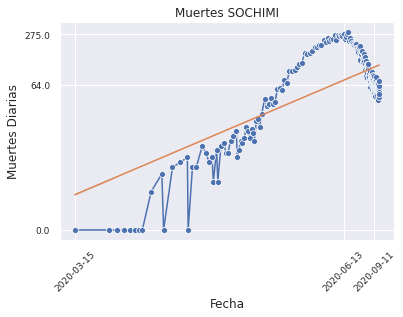

saving to file: /data/ETLcache/Muertes_ConfirmadosPCR+.png
saving backup: /data/ETLcache/Muertes_ConfirmadosPCR+_24012021_051644.png


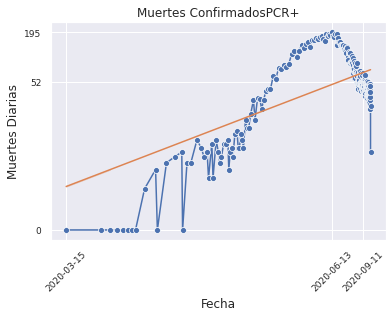

In [19]:
for p in params:
    log_log_plot(muertes,space=90,timestamp=timestamp,path=path,dpi=150,**p)

saving to file: Muertes_por_Millon_Hab._DEIS.png
saving backup: Muertes_por_Millon_Hab._DEIS.png


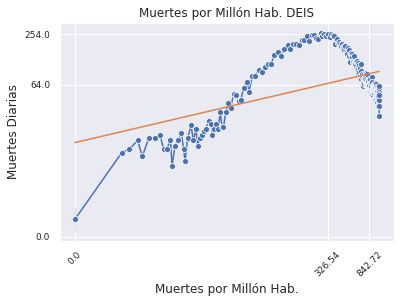

saving to file: Muertes_por_Millon_Hab._SOCHIMI.png
saving backup: Muertes_por_Millon_Hab._SOCHIMI.png


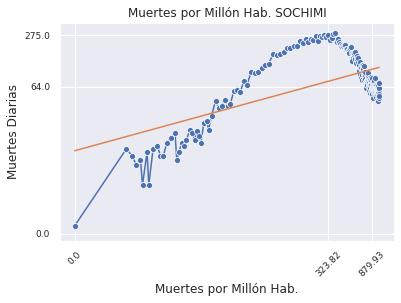

saving to file: Muertes_por_Millon_Hab._ConfirmadosPCR+.png
saving backup: Muertes_por_Millon_Hab._ConfirmadosPCR+.png


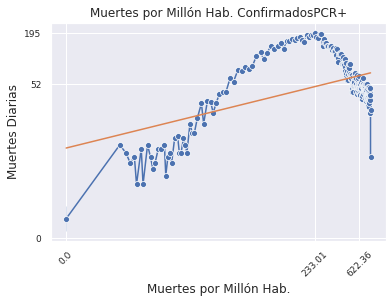

In [20]:
for p in params2:
    log_log_plot(muertes,space=90,**p,dpi=150)

In [21]:
muertes=log_inv(muertes)

In [22]:
columns=[]
for col in muertes.columns:
    columns.append(col.replace('(','_').replace(')','_'))
    #columns.append(col[0:19])
muertes.columns=columns

In [23]:
for k in ['@perez']:
    if not cnx.dialect.has_schema(cnx, k):
        print('schema '+k+' does not exist, creating it')
        cnx.execute(sqlalchemy.schema.CreateSchema(k))
    else:
        print('schema '+k+' exists, will not be created')

schema @perez exists, will not be created


In [24]:
schema='@perez'
name='muertes@perez'
print("creating table "+name+' ,schema: '+schema)
muertes.to_sql(name, schema=schema,con=cnx,if_exists='replace')
print("saving table"+path+name+timestamp+'.csv in cache')
muertes.to_csv(path+name+timestamp+'.csv',encoding='utf-8')

creating table muertes@perez ,schema: @perez
saving table/data/ETLcache/muertes@perez_24012021_051644.csv in cache


In [32]:
url='https://docs.google.com/spreadsheets/d/1mLx2L8nMaRZu0Sy4lyFniDewl6jDcgnxB_d0lHG-boc/export?gid=828979356&format=csv'
nacional=pd.read_csv(url,header=[1],encoding='utf-8')

In [33]:
nacional

,FECHA REAL\nde los datos (e.g. confirmados a las 9pm de cada día),Test PCR notificados acumulados,Laboratorios que reportan en esa fecha,Confirmados acumulados totales (incluye asintomáticos),Confirmados asintomáticos acumulados totales,Muertes acumuladas totales,Pacientes actualmente en UCI,Pacientes \ncovid positivo actualmente\nen cama básica,Pacientes\ncovid positivo\nactualmente\nen cama media,Pacientes\ncovid positivo\nactualmente\nen UTI,...,Pacientes covid FALLECIDOS (24HRS),Pacientes covid en VMI fallecidos (24HRS),Pacientes covid positivos que iniciaron síntomas ese día,Pacientes covid positivos notificados en Epivigila ese día,Pacientes sospechosos acumulados en Epivigila,Confirmados acumulados ingresados en Epivigila,Pacientes acumulados cn info de ingreso a hospital,Pacientes acumulados cn info de ingreso a UTI/UCI,Confirmados dos\nsemanas atras\nmenos muertos\nhasta día actual,Nuevos confirmados dos semanas atrás menos nuevos muertos hoy
0,2020-03-06,-,-,7.0,-,0.0,-,-,-,-,...,-,-,12.0,1,-,-,-,-,-,NaN
1,2020-03-07,-,-,9.0,-,0.0,-,-,-,-,...,-,-,13.0,2,-,-,-,-,-,NaN
2,2020-03-08,-,-,12.0,-,0.0,-,-,-,-,...,-,-,24.0,6,-,-,-,-,-,NaN
3,2020-03-09,-,-,17.0,-,0.0,-,-,-,-,...,-,-,34.0,2,-,-,-,-,-,NaN
4,2020-03-10,-,-,23.0,-,0.0,-,-,-,-,...,-,-,63.0,11,270,18,-,-,-,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2020-10-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,2020-10-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,2020-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238,2020-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
url='https://docs.google.com/spreadsheets/d/1mLx2L8nMaRZu0Sy4lyFniDewl6jDcgnxB_d0lHG-boc/export?gid=828979356&format=csv'
nacional=pd.read_csv(url,header=[1],encoding='utf-8')
headers=[x.replace('\n','') for x in nacional.columns]
headers=['Fecha' if 'FECHA' in x else x.replace(' ','_').replace('(','_').replace(')','_') for x in headers]
nacional.columns=headers
nacional=nacional.replace('-',np.nan)
nacional=nacional.replace(' ',np.nan)
nacional=nacional.astype('float',errors='ignore')
nacional['Fecha']=pd.to_datetime(nacional['Fecha'],errors='coerce',format='%Y-%m-%d')
nacional['Fecha']=nacional['Fecha'].dt.to_pydatetime()
nacional['Camas UCI Desocupadas']=nacional['Camas_UCI_totales']-nacional['Camas_UCI_ocupadas__no_solo_covid_']
nacional['VMI Desocupadas']=nacional['VMI_totales']-nacional['Pacientes_en_vent._mecánica__no_solo_covid_']

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [28]:
pd.to_numeric(nacional['Camas_UCI_totales'],errors='coerce')-pd.to_numeric(nacional['Camas_UCI_ocupadas__no_solo_covid_'],errors='coerce')

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
235   NaN
236   NaN
237   NaN
238   NaN
239   NaN
Length: 240, dtype: float64

In [29]:
nacional['Camas_UCI_totales']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
235    NaN
236    NaN
237    NaN
238    NaN
239    NaN
Name: Camas_UCI_totales, Length: 240, dtype: object

In [30]:
nacional['Camas_UCI_ocupadas__no_solo_covid_']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
235    NaN
236    NaN
237    NaN
238    NaN
239    NaN
Name: Camas_UCI_ocupadas__no_solo_covid_, Length: 240, dtype: object

In [31]:
nacional

,Fecha,Test_PCR_notificados_acumulados,Laboratorios_que_reportan_en_esa_fecha,Confirmados_acumulados_totales__incluye_asintomáticos_,Confirmados_asintomáticos_acumulados_totales,Muertes_acumuladas_totales,Pacientes_actualmente_en_UCI,Pacientes_covid_positivo_actualmenteen_cama_básica,Pacientescovid_positivoactualmenteen_cama_media,Pacientescovid_positivoactualmenteen_UTI,...,Pacientes_covid_FALLECIDOS__24HRS_,Pacientes_covid_en_VMI_fallecidos__24HRS_,Pacientes_covid_positivos_que_iniciaron_síntomas_ese_día,Pacientes_covid_positivos_notificados_en_Epivigila_ese_día,Pacientes_sospechosos_acumulados_en_Epivigila,Confirmados_acumulados_ingresados_en_Epivigila,Pacientes_acumulados_cn_info_de_ingreso_a_hospital,Pacientes_acumulados_cn_info_de_ingreso_a_UTI/UCI,Confirmados_dossemanas_atrasmenos_muertoshasta_día_actual,Nuevos_confirmados_dos_semanas_atrás_menos_nuevos_muertos_hoy
0,2020-03-06,NaN,NaN,7.0,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,12.0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-07,NaN,NaN,9.0,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,13.0,2,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-03-08,NaN,NaN,12.0,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,24.0,6,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-03-09,NaN,NaN,17.0,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,34.0,2,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-03-10,NaN,NaN,23.0,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,63.0,11,270,18,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2020-10-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,2020-10-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,2020-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238,2020-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
nacional['VMI no-COVID']=nacional['Pacientes_en_vent._mecánica__no_solo_covid_']-nacional['Pacientescovid_positivoactualmente_en_vent._mecánica']+nacional['Pacientes_sospecha_covid_actualmente_en_vent._mecánica']

In [27]:
nacional['UCI no-COVID']=nacional['Camas_UCI_ocupadas__no_solo_covid_']-nacional['Pacientescovid_positivoactualmenteen_UCI']

In [28]:
name='nacional@perez'
print("creating table "+name+' ,schema: '+schema)
nacional.to_sql(name, schema=schema,con=cnx,if_exists='replace')
print("saving table"+path+name+timestamp+'.csv in cache')
nacional.to_csv(path+name+timestamp+'.csv',encoding='utf-8')

creating table nacional@perez ,schema: @perez
saving table/data/ETLcache/nacional@perez_06122020_224126.csv in cache


In [29]:
os.system('jupyter nbconvert --output /home/jovyan/work/ETLdocs/' + 'ETL_covid-chile.html' + ' --to html ' + 
          '/home/jovyan/work/ETL/covid-chile.ipynb')

65280